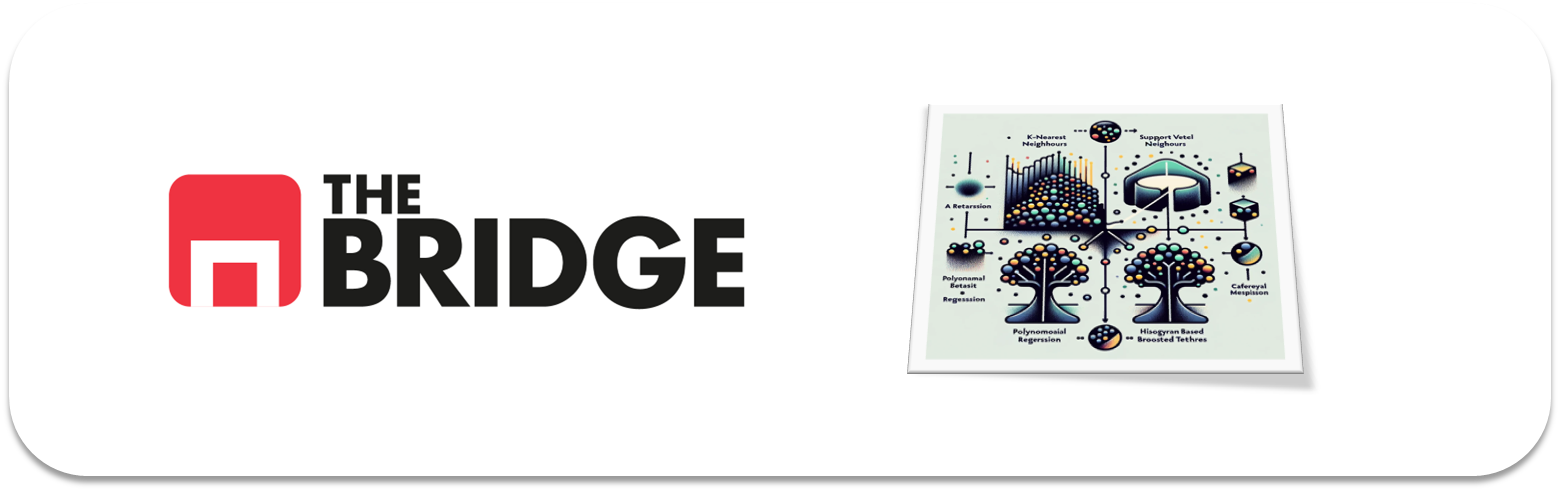

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [18]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier


### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [2]:
df = pd.read_csv("./data/wines_dataset.csv", sep = '|')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


Siguiendo el esquema:
1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  <- PARTIMOS DE AQUI
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)
    Categoricas -> 0-1 -> MinMax (a,b), con a < b
    Categoricas -> 0 a 10 y numericas -> StandardScaler -> 2 juegos 
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  TIEMPO es la clave -> 1) Tuneo/Ajusto los hiperparámetros; 2) validación cruzada (set de validación)
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7) (hiperparametro -> class_weight)

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

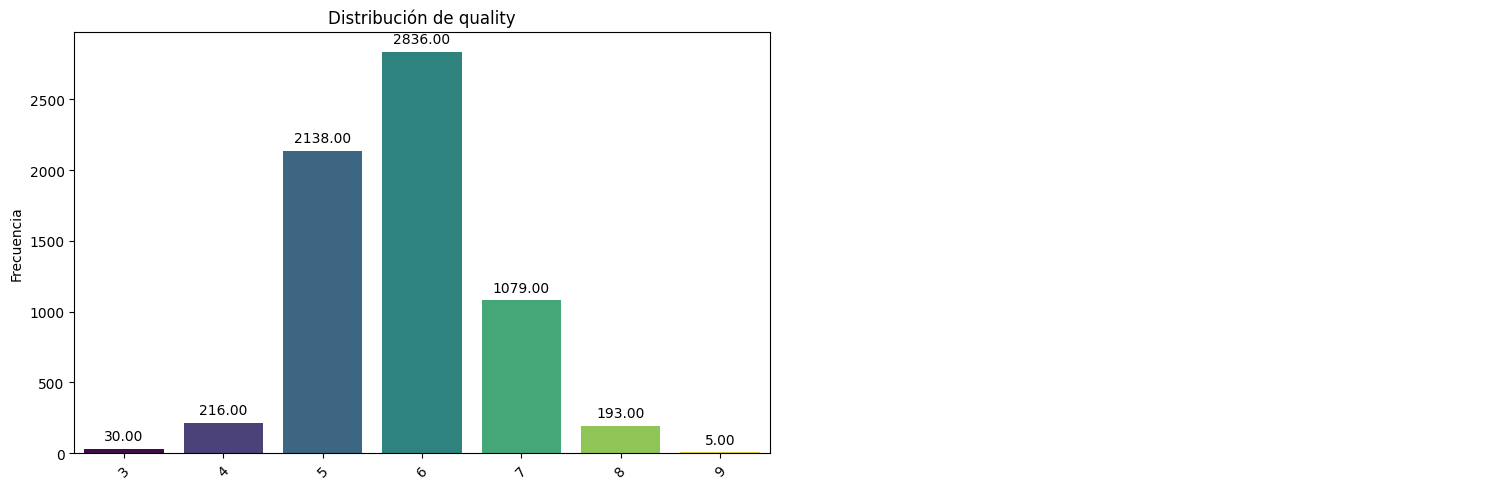

In [3]:
bt.pinta_distribucion_categoricas(df, ['quality'], mostrar_valores= True, relativa= False)

In [4]:
df.quality.value_counts(normalize =True)

quality
6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: proportion, dtype: float64

In [5]:
train_set, test_set = train_test_split(df, test_size=0.20, random_state=42)

In [6]:
target = 'quality'

In [7]:
corr = df.corr(numeric_only=True)
corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64

- Nos vamos a quedar con todas las columnas. No hay fuertes correlaciones ni con respecto del target a las variables ni entre las propias variables. Veamos que hacer con class, si merece la pena transformarla a numérica o eliminarla.

In [8]:
df.groupby('class')['quality'].value_counts(normalize=True)

class  quality
red    5          0.425891
       6          0.398999
       7          0.124453
       4          0.033146
       8          0.011257
       3          0.006254
white  6          0.448755
       5          0.297468
       7          0.179665
       8          0.035729
       4          0.033279
       3          0.004083
       9          0.001021
Name: proportion, dtype: float64

In [9]:
train_set.drop('class', axis = 1, inplace=True)
test_set.drop('class', axis = 1, inplace=True)

- Elimino la columna class. No parece ser determinante en la calidad del vino, si no más bien en la descripción del mismo como característica. 

In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


- Para modelos basados en distancia hay que transformar y estandarizar los datos. Ojo con la columna Acido Citrico que posee valores mínimos de 0

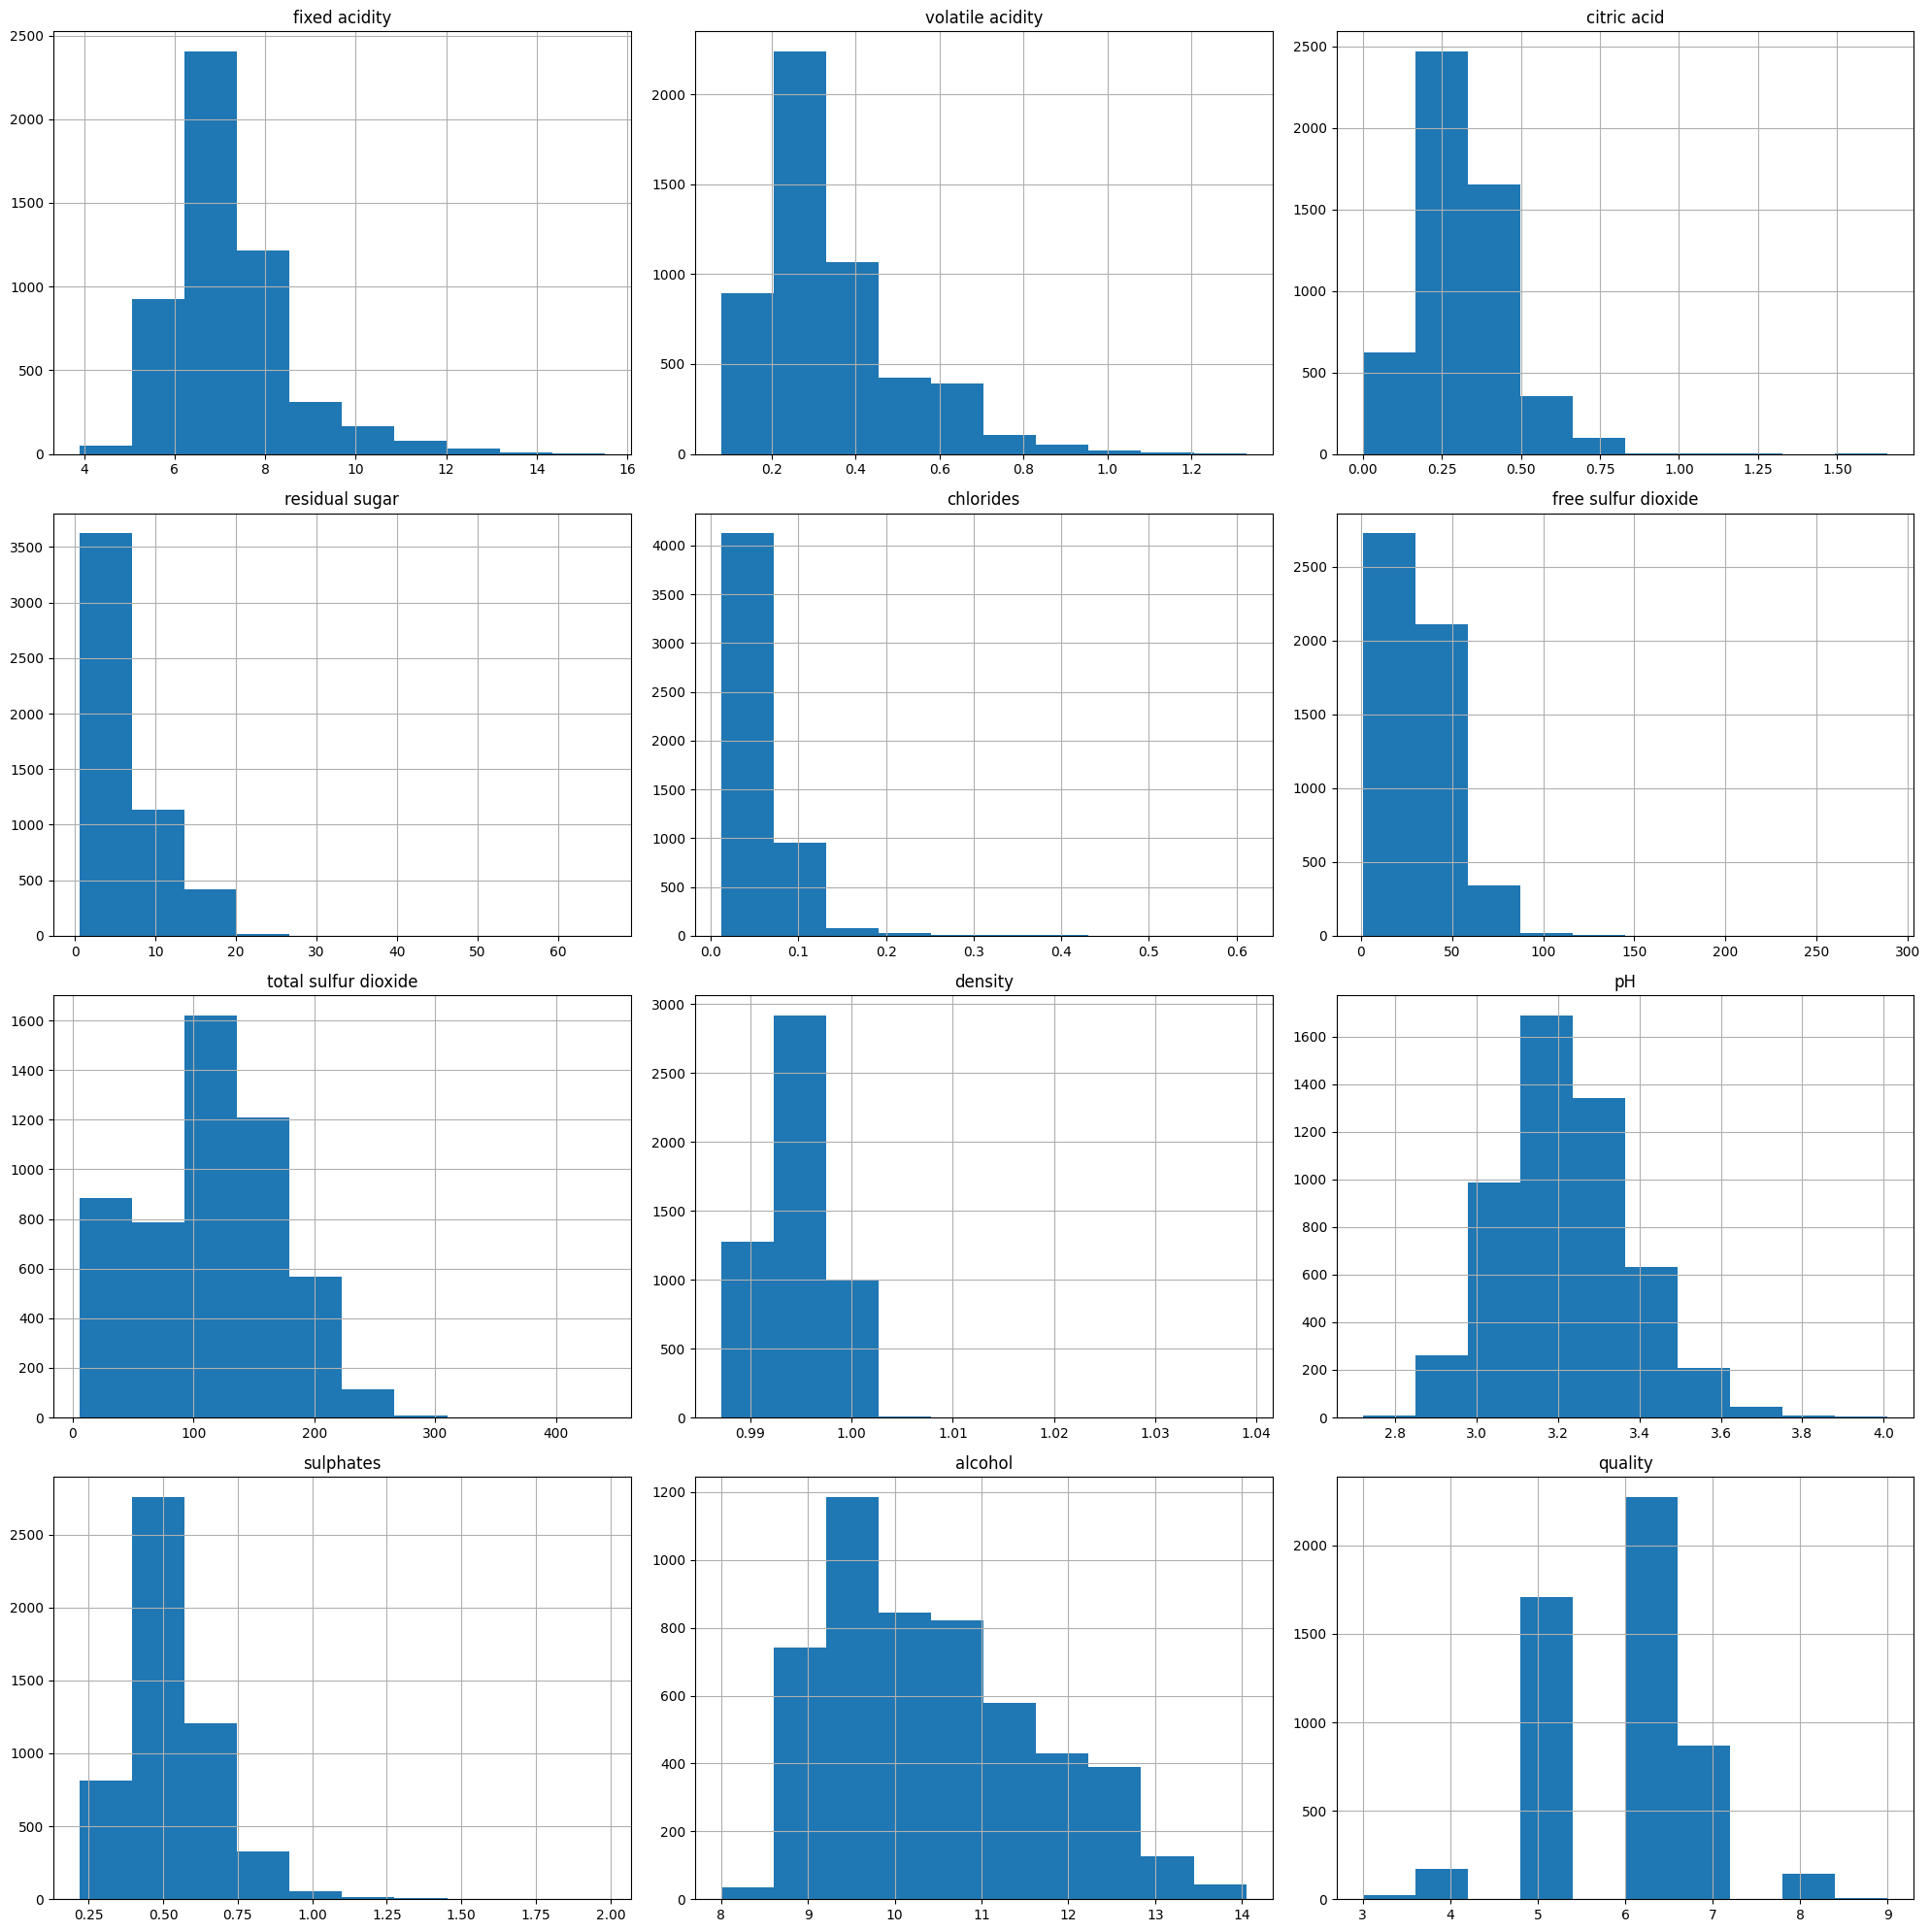

In [11]:
train_set.hist(figsize = (20,20))
plt.tight_layout()

- Definimos las variables a transformar y estandarizar para el modelo baseline de KNN

In [12]:
feat_transform = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide','alcohol']

In [13]:
train_set[feat_transform].describe()

,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,alcohol
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,5.466615,0.055733,30.563306,115.592457,10.490439
std,4.783581,0.032656,18.004967,56.805306,1.194099
min,0.600000,0.012000,1.000000,6.000000,8.000000
25%,1.800000,0.038000,17.000000,76.000000,9.500000
50%,3.000000,0.047000,29.000000,118.000000,10.300000
75%,8.100000,0.065000,41.000000,156.000000,11.300000
max,65.800000,0.611000,289.000000,440.000000,14.050000


In [16]:
from sklearn.preprocessing import OrdinalEncoder
categories = [[3, 4, 5, 6, 7, 8, 9]]
ordinal_encoder = OrdinalEncoder(categories= categories)
train_set['quality'] = ordinal_encoder.fit_transform(train_set[['quality']])
test_set['quality'] = ordinal_encoder.transform(test_set[['quality']])

In [17]:
X_train = train_set.drop(target, axis=1)
y_train = train_set[target]
X_test = test_set.drop(target, axis=1)
y_test = test_set[target]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [18]:
for col in feat_transform:
    X_train_scaled[col] = X_train_scaled[col].apply(np.log)
    X_test_scaled[col] = X_test_scaled[col].apply(np.log)

In [19]:
feat_esc = X_train_scaled.columns.to_list()
feat_esc

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [20]:
scaler = StandardScaler()
X_train_scaled[feat_esc]= scaler.fit_transform(X_train_scaled[feat_esc])
X_test_scaled[feat_esc] = scaler.transform(X_test_scaled[feat_esc])

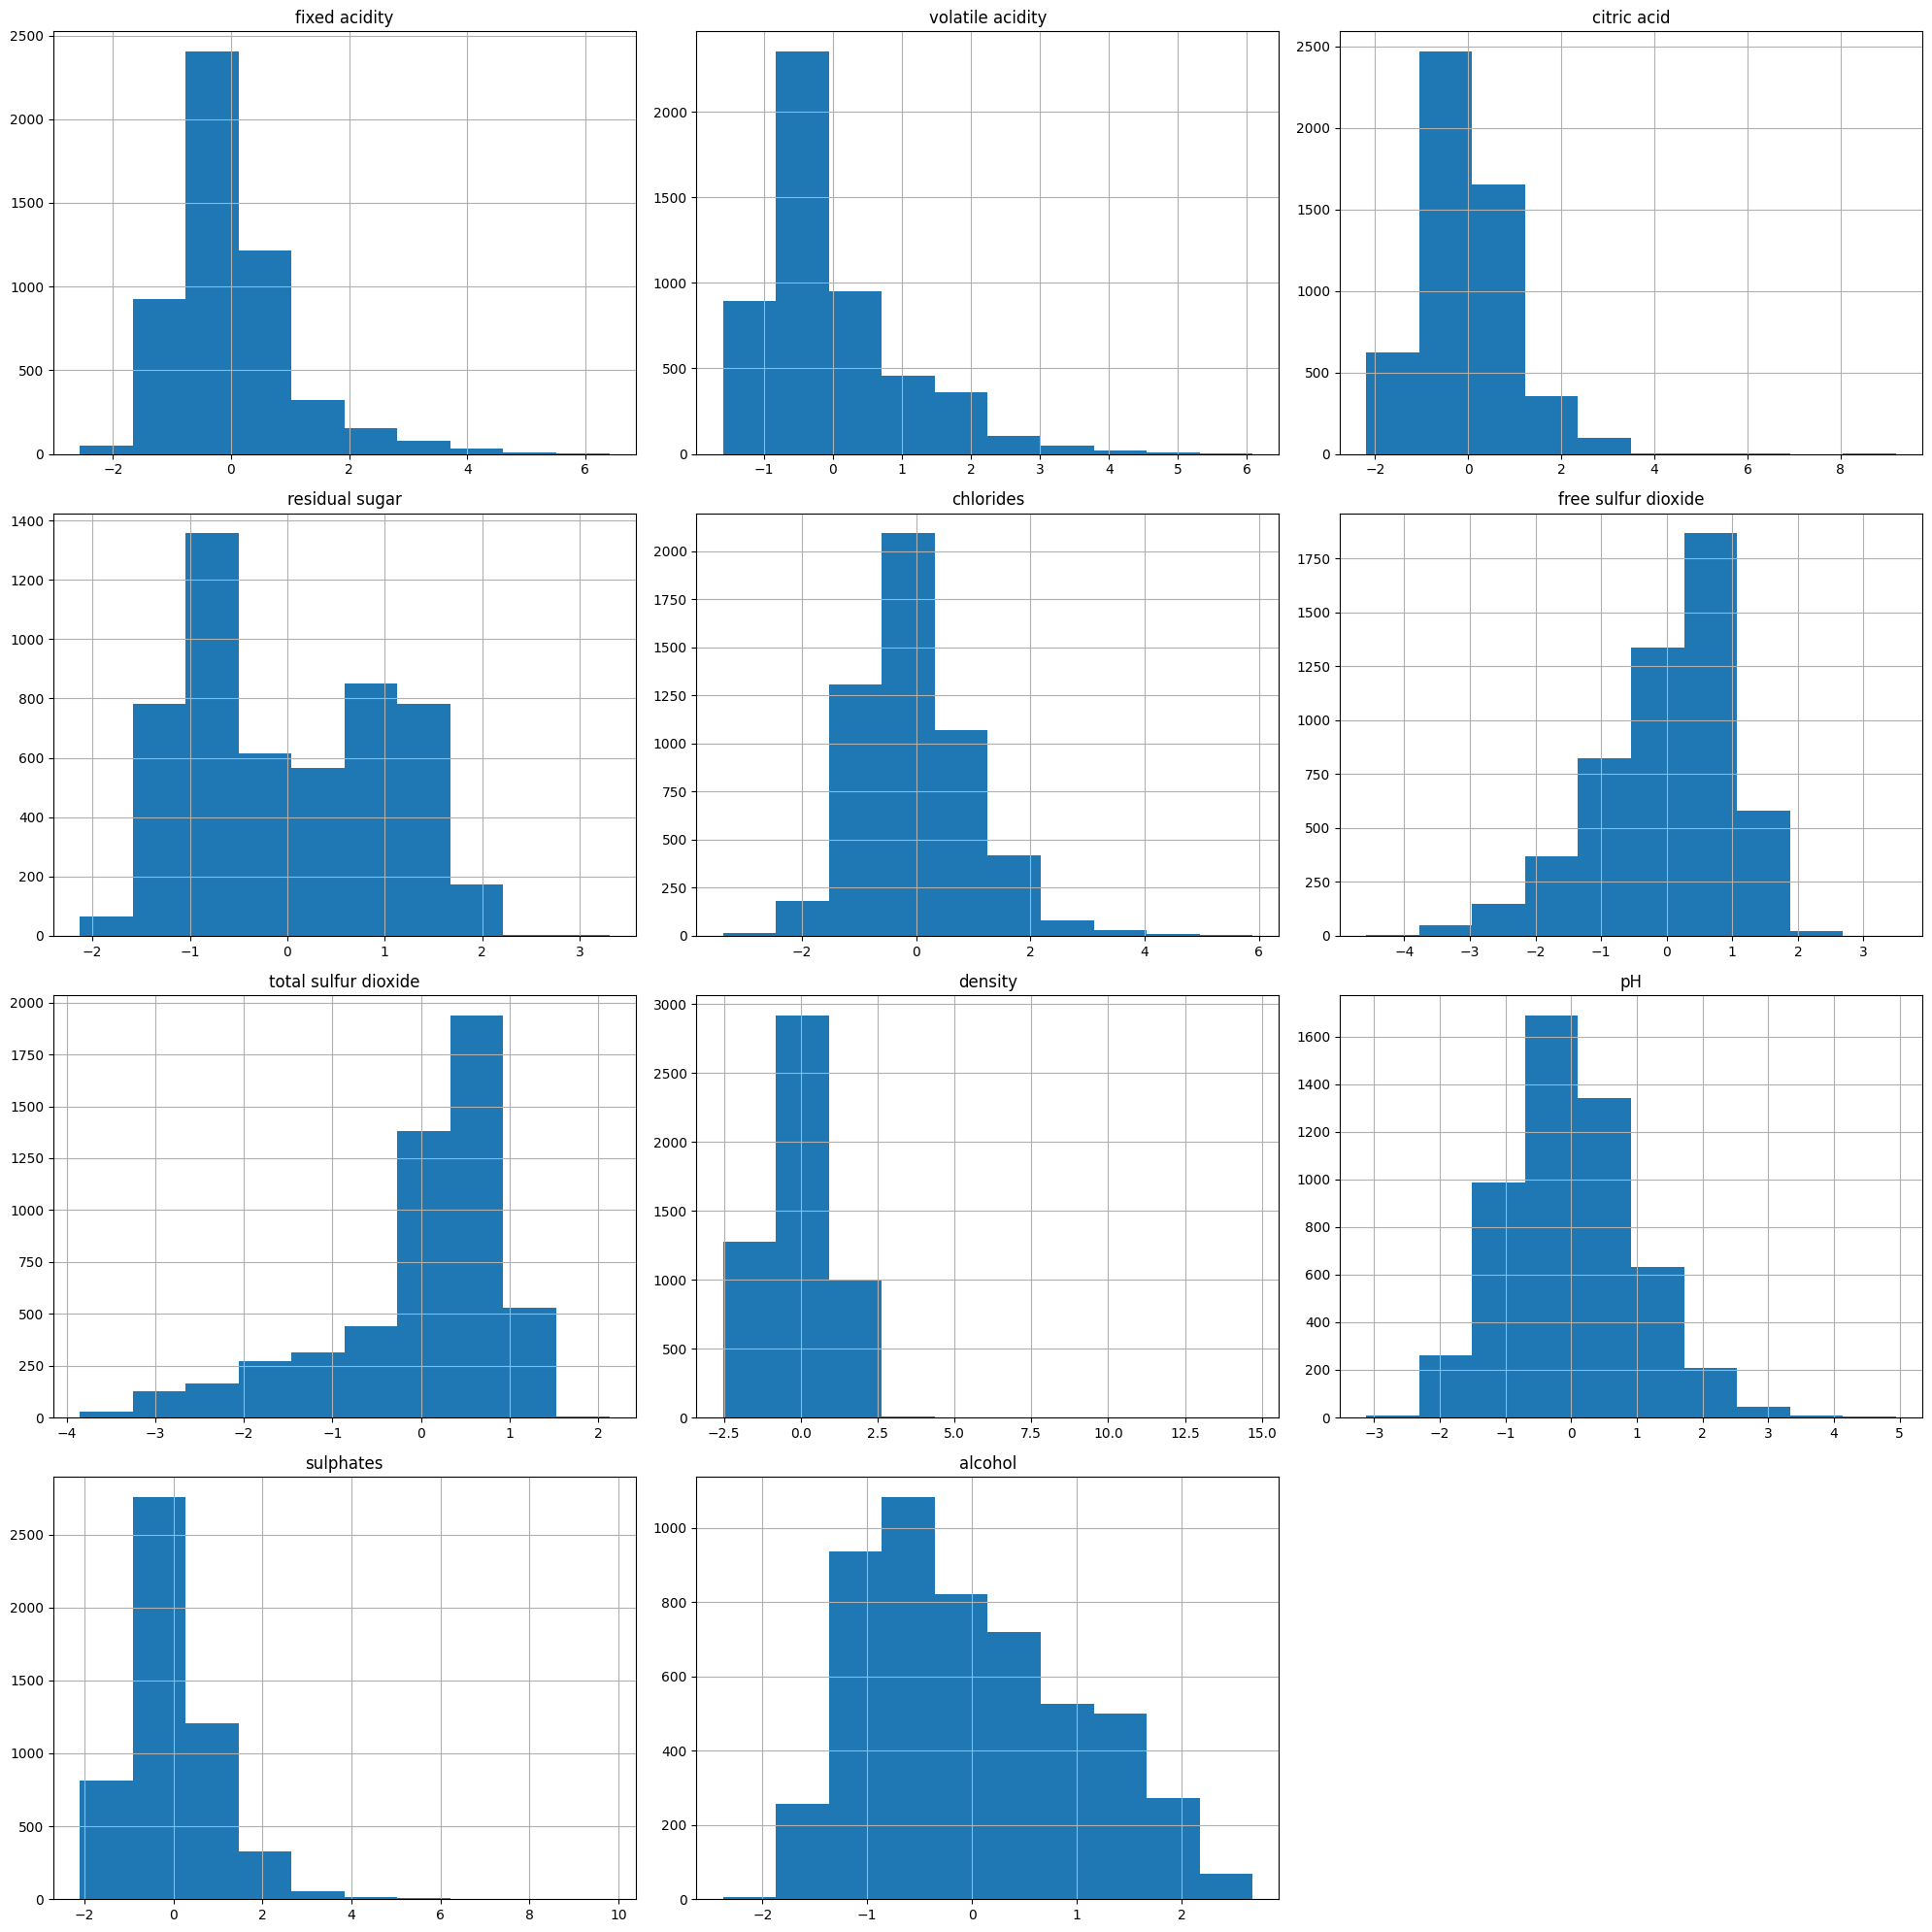

In [21]:
X_train_scaled.hist(figsize = (20,20))
plt.tight_layout()

In [ ]:
#fig, ax = plt.subplots(len(features_num),3, figsize=(20,50))
#for index, feature in enumerate(features_num):
# Aplicamos raíz cuadrada a las features ya que algunas tienen valor 0 como mínimo 
#log_feature = np.log1p(set_train[feature])
#sqrt_feature = np.sqrt(set_train[feature])
#sns.histplot(set_train, x=feature, hue='class', bins=50, kde=True, ax=ax[index, 0])
#sns.histplot(set_train, x=log_feature, hue='class', bins=50, kde=True, ax=ax[index, 1])
#sns.histplot(set_train, x=sqrt_feature, hue='class', bins=50, kde=True, ax=ax[index, 2])
#ax[index, 0].set_xlabel('')
#ax[index, 1].set_xlabel('')
#ax[index, 2].set_xlabel('')
#ax[index, 0].set_ylabel(feature)
#ax[index, 1].set_ylabel('')
#ax[index, 2].set_ylabel('')
#plt.tight_layout();

- Con los datos ya transformados, empezamos con la comparacion de modelos mediante validacion cruzada

In [27]:
rf_clf = RandomForestClassifier(random_state= 42)
lgb_clf = LGBMClassifier(random_sate = 42, verbose = -100)
xgb_clf = XGBClassifier(random_state = 42)
knn = KNeighborsClassifier(n_neighbors=5)

model_names = ["KNeighbors","Random Forest","XGBoost","LightGBM"]
model_set = [knn, rf_clf, xgb_clf, lgb_clf]

In [28]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre != "KNeighbors":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

KNeighborsClassifier()
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
LGBMClassifier(random_sate=42, verbose=-100)


In [29]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <KNeighbors>, Accuracy_CV: 0.25389342464958026
Model <Random Forest>, Accuracy_CV: 0.335700976681839
Model <XGBoost>, Accuracy_CV: 0.33452885471284394
Model <LightGBM>, Accuracy_CV: 0.33642141702935546
El ganador es LightGBM


In [33]:
lgb_clf = LGBMClassifier(random = 42,verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = GridSearchCV(lgb_clf, 
                               cv = 5,
                               param_grid= param_grid, 
                               scoring = "balanced_accuracy")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", lgb_grid.best_score_)


LGB best_score: 0.3423521623013511


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.71      0.23      0.35        43
         2.0       0.74      0.71      0.73       432
         3.0       0.66      0.75      0.70       562
         4.0       0.60      0.58      0.59       210
         5.0       0.85      0.49      0.62        47

    accuracy                           0.68      1300
   macro avg       0.59      0.46      0.50      1300
weighted avg       0.68      0.68      0.67      1300



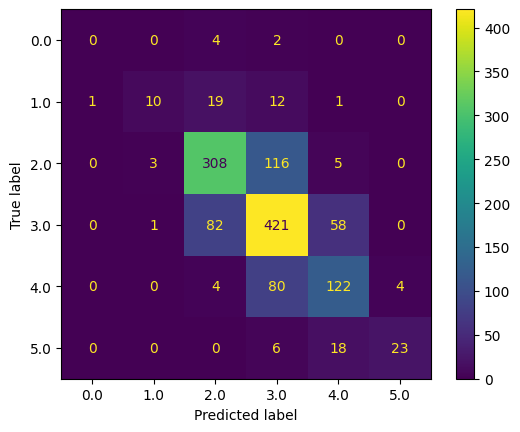

In [34]:
y_pred =lgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
train_set_reg,test_set_reg = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
train_set_reg['class'] = (train_set_reg['class'] == "red").astype(int) # Clase 0 -> white, Clase 1 -> red


In [6]:
test_set_reg['class'] = (test_set_reg['class'] == "red").astype(int)

In [7]:
target = 'alcohol'

In [8]:
X_train_reg = train_set_reg.drop(target, axis = 1)
y_train_reg = train_set_reg[target]
X_test_reg = test_set_reg.drop(target, axis = 1)
y_test_reg = test_set_reg[target]
X_train_reg_scaled = X_train_reg.copy()
X_test_reg_scaled = X_test_reg.copy()

In [9]:
X_train_reg

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,class
1916,7.9,0.18,0.40,2.20,0.049,38.0,67.0,0.99600,3.33,0.93,5,1
947,7.1,0.18,0.74,15.60,0.044,44.0,176.0,0.99960,3.38,0.67,6,0
877,7.6,0.51,0.24,1.20,0.040,10.0,104.0,0.99200,3.05,0.29,6,0
2927,6.0,0.25,0.28,7.70,0.053,37.0,132.0,0.99489,3.06,0.50,6,0
6063,9.0,0.38,0.41,2.40,0.103,6.0,10.0,0.99604,3.13,0.58,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3772,6.4,0.24,0.50,11.60,0.047,60.0,211.0,0.99660,3.18,0.57,5,0
5191,6.6,0.22,0.28,12.05,0.058,25.0,125.0,0.99856,3.45,0.45,5,0
5226,6.6,0.20,0.38,7.90,0.052,30.0,145.0,0.99470,3.32,0.56,7,0
5390,7.3,0.41,0.29,1.80,0.032,26.0,74.0,0.98889,2.96,0.35,8,0


In [10]:
feat_transform = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide']

In [11]:
for col in feat_transform:
    X_train_reg_scaled[col] = X_train_reg_scaled[col].apply(np.log)
    X_test_reg_scaled[col] = X_test_reg_scaled[col].apply(np.log)

In [13]:
X_train_reg_scaled

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,class
1916,7.9,0.18,0.40,0.788457,-3.015935,3.637586,4.204693,0.99600,3.33,0.93,5,1
947,7.1,0.18,0.74,2.747271,-3.123566,3.784190,5.170484,0.99960,3.38,0.67,6,0
877,7.6,0.51,0.24,0.182322,-3.218876,2.302585,4.644391,0.99200,3.05,0.29,6,0
2927,6.0,0.25,0.28,2.041220,-2.937463,3.610918,4.882802,0.99489,3.06,0.50,6,0
6063,9.0,0.38,0.41,0.875469,-2.273026,1.791759,2.302585,0.99604,3.13,0.58,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3772,6.4,0.24,0.50,2.451005,-3.057608,4.094345,5.351858,0.99660,3.18,0.57,5,0
5191,6.6,0.22,0.28,2.489065,-2.847312,3.218876,4.828314,0.99856,3.45,0.45,5,0
5226,6.6,0.20,0.38,2.066863,-2.956512,3.401197,4.976734,0.99470,3.32,0.56,7,0
5390,7.3,0.41,0.29,0.587787,-3.442019,3.258097,4.304065,0.98889,2.96,0.35,8,0


In [14]:
feat_esc = X_train_reg_scaled.columns.to_list()
scaler = StandardScaler()
X_train_reg_scaled[feat_esc]= scaler.fit_transform(X_train_reg_scaled[feat_esc])
X_test_reg_scaled[feat_esc] = scaler.transform(X_test_reg_scaled[feat_esc])

In [15]:

model_names = ["Regresion Lineal","Random Forest","XGBoost","LightGBM"]
lr_clf = LinearRegression()
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)


model_set = [lr_clf, rf_clf, xgb_clf, lgb_clf,]

In [16]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_reg_scaled, y_train_reg, cv = 3, scoring = "neg_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train_reg, y_train_reg, cv = 3, scoring = "neg_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
LGBMRegressor(random_state=42, verbose=-100)


In [17]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 0.6113779420401747
Model <Random Forest>, RMSE_CV: 0.41780518313212583
Model <XGBoost>, RMSE_CV: 0.3956957475612494
Model <LightGBM>, RMSE_CV: 0.3915374170082449
El ganador es LightGBM


In [19]:
lgb_clf = LGBMRegressor(verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


lgb_grid.fit(X_train_reg, y_train_reg)
print("LGB best_score:", np.sqrt(-lgb_grid.best_score_))

LGB best_score: 0.37939650650342593


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [21]:
y_pred = lgb_grid.best_estimator_.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg,y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test_reg,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 0.22882945818883801
MAPE: 0.021622734040935558
RMSE: 0.36006403125080566


In [22]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

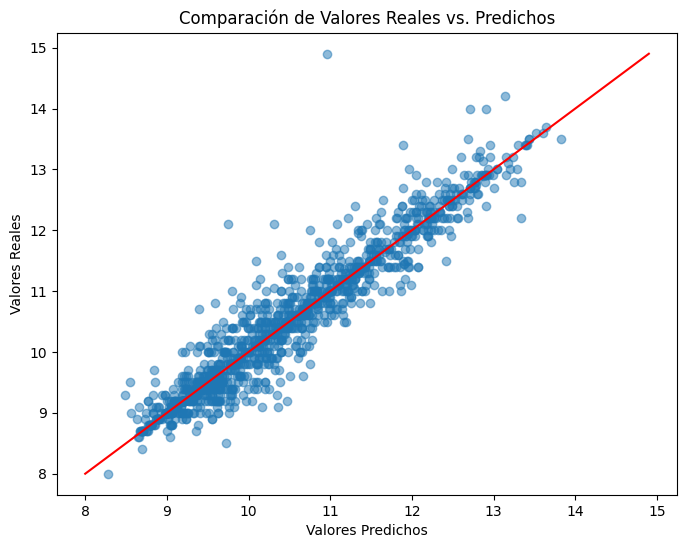

In [23]:
plot_predictions_vs_actual(y_test_reg, y_pred)